In [1]:
import os, sys

THIS_DIR = os.path.dirname(os.path.abspath("__file__"))
PARENT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
sys.path.append(PARENT_DIR)
import torch
import numpy as np
from integrator import Mid_point
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == "cpu":
    print("No GPU found!")
else:
    print("Great, a GPU is there")
    # get_ipython().system('nvidia-smi')
print("=" * 50)

from scipy import sparse
from scipy.sparse import spdiags,identity
from scipy.sparse import csr_matrix
torch.set_grad_enabled(True)
np.random.seed(100)
torch.manual_seed(100)

Great, a GPU is there


## Define the parameters

In [2]:
class params:
    t_final       = 60        # Final simulation time
    Nt            = 1201      # Number of temporal nodes
    N             = 256       # Number of spatial nodes 
    L             = 10         # [-L,L] spatial domain
    speed = 1
    h             = 2*L/N     # Spatial step size
params=params

## Construct the second order derivative matrices

In [3]:
10/1000

0.01

In [4]:

e        = np.ones(params.N)
D2       = (1/params.h**2)*spdiags([e,-2*e,e], [-1,0,1], params.N, params.N)
D2       = D2.tolil()
D2[-1,0] = (1/params.h**2)
D2[0,-1] = (1/params.h**2)
D2       = D2.tocsr()

D2 = params.speed*D2

$$
q_t =  p
\\
p_t = q_{xx}
\\
z=[p,q]^T
$$

In [5]:
def nls(t, z):
    len_z = len(z)
    q, p  = z[: len_z // 2], z[len_z // 2 :]
    dqdt  = p 
    dpdt  = D2*q  
    dzdt  = np.concatenate((dqdt, dpdt), axis=0)
    return dzdt

In [6]:
def nls_jacobian( z):
    len_z = len(z)
    q, p  =  z[: len_z // 2], z[len_z // 2 :]
    q     =  q.squeeze()
    p     =  p.squeeze()
    null  =  csr_matrix((params.N, params.N))
    Id    =  identity(params.N)
    R1q   =  null
    R1p   =  Id 
    R1    =  sparse.hstack((R1q,R1p))
    R2q   =  D2 
    R2p   =  null
    R2    =  sparse.hstack((R2q,R2p))
    J     =  sparse.vstack((R1,R2))
    return J

In [7]:
t_train   = np.linspace(0,params.t_final,params.Nt).T
t_train   = t_train.squeeze()
x         = np.linspace(-params.L,params.L,params.N)
[X,T]     = np.meshgrid(x,t_train)

In [8]:
t_train;

In [9]:
freqs = np.arange(1.5,4,0.2)
len(freqs)

13

In [10]:
# yy = np.cosh(x)
# plt.plot(x,yy), np.imag(yy)

iter: 0 and freq: 0.5!
iter: 1 and freq: 0.6!
iter: 2 and freq: 0.7!
iter: 3 and freq: 0.7999999999999999!
iter: 4 and freq: 0.8999999999999999!
iter: 5 and freq: 0.9999999999999999!
iter: 6 and freq: 1.0999999999999999!
iter: 7 and freq: 1.1999999999999997!
iter: 8 and freq: 1.2999999999999998!
iter: 9 and freq: 1.4!


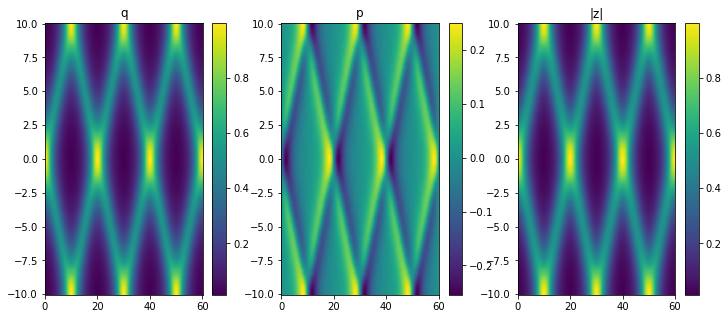

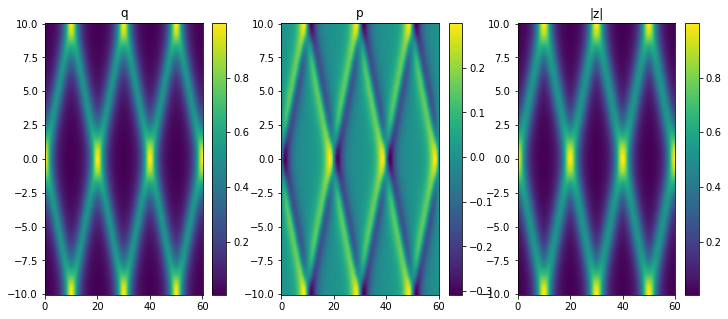

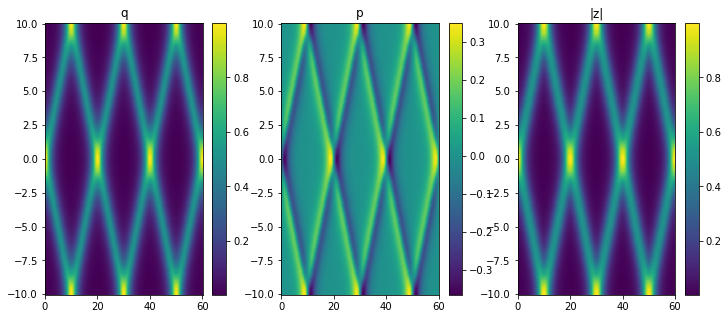

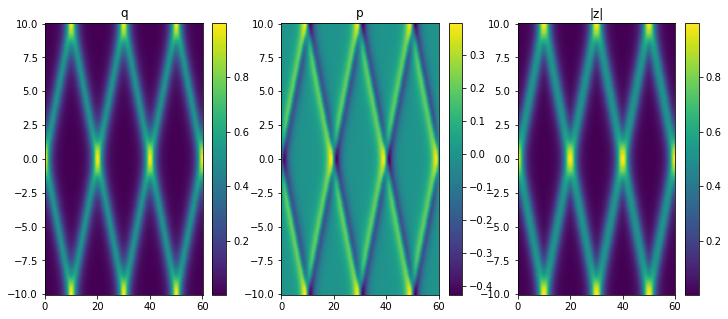

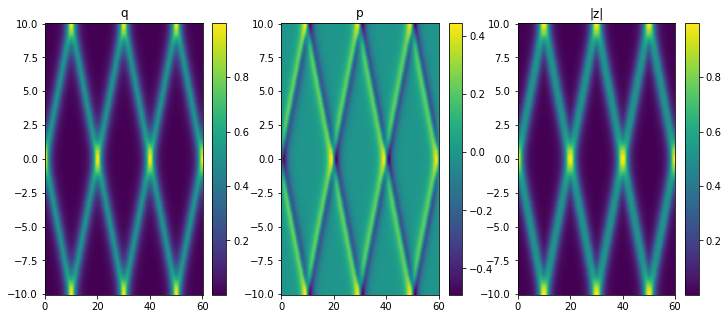

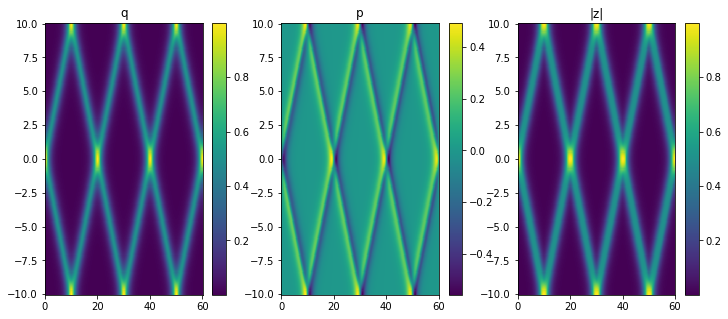

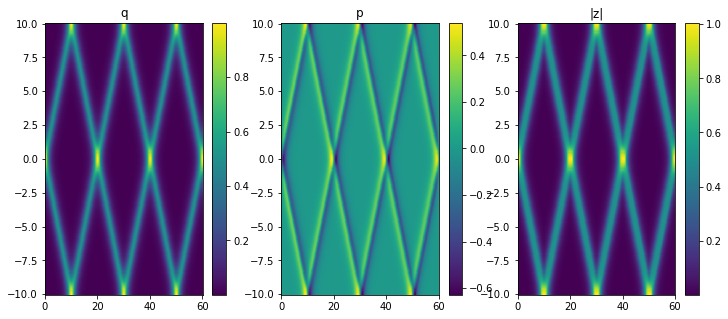

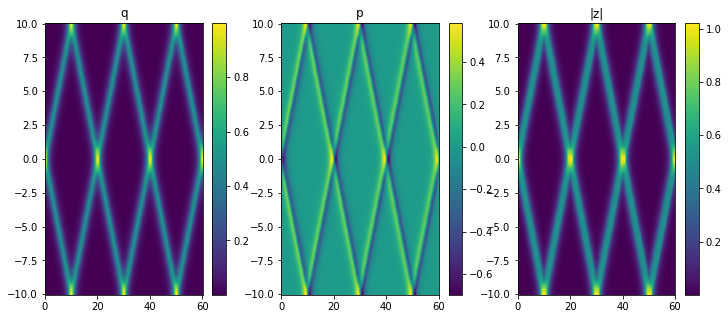

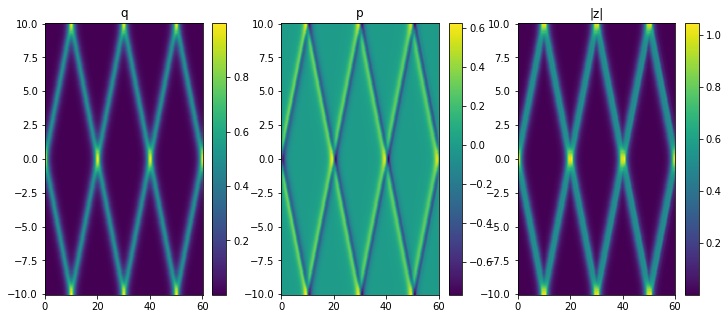

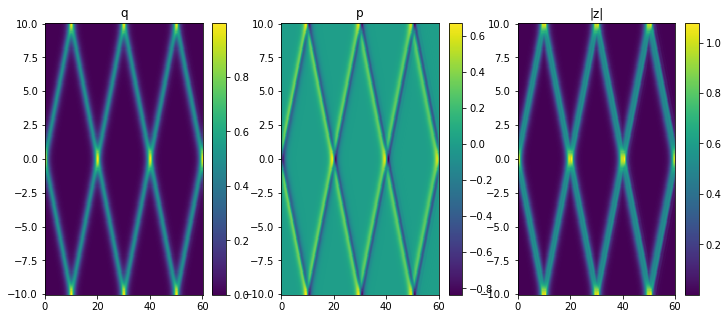

In [11]:
# freqs = np.arange(1,2,0.05)
freqs = np.arange(0.5,1.5,0.1)
all_data = []
all_deri_data = []

for i,f in enumerate(freqs):
    print(f'iter: {i} and freq: {f}!')

    phi       = 1/np.cosh(f*x)


    y0        = np.concatenate((np.real(phi), np.imag(phi)), axis=0).reshape(-1,1)
    sol_train = Mid_point(nls,nls_jacobian,y0,t_train)


    fig       = plt.figure(figsize=(12, 5))
    q, p      = sol_train[:params.N,:], sol_train[params.N:,:]
    abs_phi   = np.sqrt(q**2+p**2)
    plt.subplot(1,3,1)
    plt.pcolormesh(T,X,q.T)
    plt.colorbar()
    plt.title('q')
    plt.subplot(1,3,2)
    plt.pcolormesh(T,X,p.T)
    plt.colorbar()
    plt.title('p')
    plt.subplot(1,3,3)
    plt.pcolormesh(T,X,abs_phi.T)
    plt.colorbar()
    plt.title('|z|')

    dzdt=np.zeros((sol_train.shape))
    for j in range(params.Nt):
        dzdt[:,j]=nls(0,sol_train[:,j])

    from scipy.io import savemat

    all_data.append(sol_train)
    all_deri_data.append(dzdt)

data = {"z":np.stack(all_data, axis=0), "dz":np.stack(all_deri_data, axis=0), "x": x, "t":t_train, "freqs":freqs}

savemat("wave_data_multiple.mat", data)

In [12]:
np.stack(all_data, axis=0).shape

(10, 512, 1201)

In [13]:
# np.stack(all_data, axis=0).shape
Xd = np.hstack(all_data)

In [14]:
Xd.shape

(512, 12010)

In [15]:
S = np.linalg.svd(Xd, full_matrices=False)

0.999956915124837

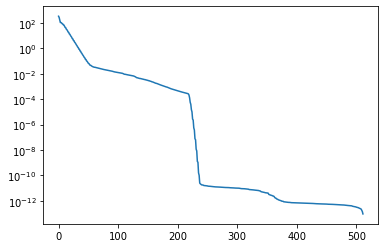

In [16]:
plt.semilogy(S[1])
np.sum(S[1][:150])/np.sum(S[1])

In [17]:
np.sum(S[1][:75])/np.sum(S[1])

0.9995156054244462

In [18]:
U,S,V = np.linalg.svd(Xd)

In [36]:
U.shape, S.shape, np.sum(S[:40])/np.sum(S)

((512, 512), (512,), 0.9979998225440528)

In [30]:
V_proj = U[:,:40]

Xd_rec = V_proj@(V_proj.T)@Xd
Xd_rec.shape

(512, 12010)

In [31]:
# sol_rec.shape

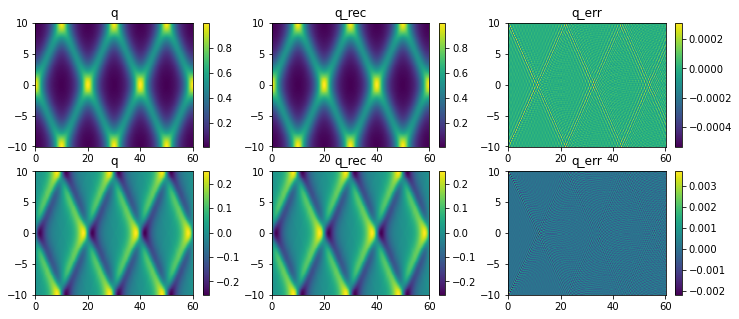

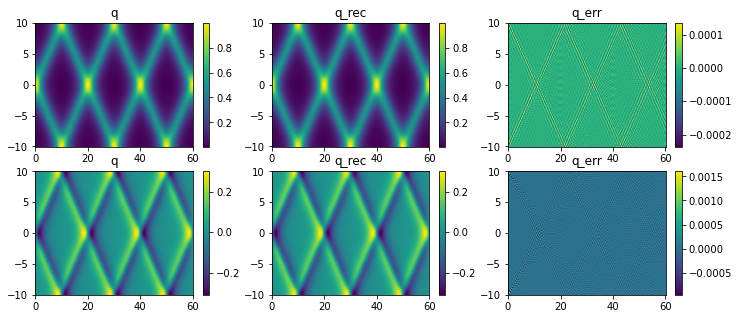

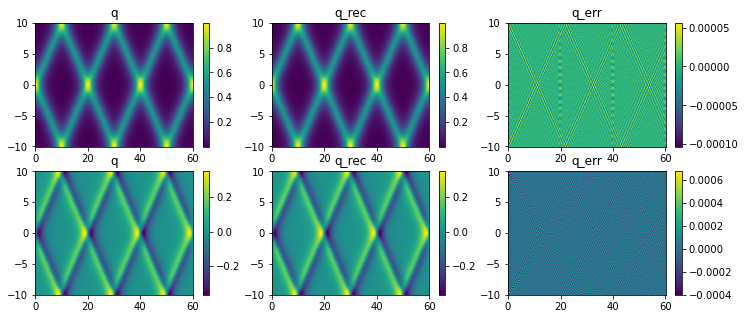

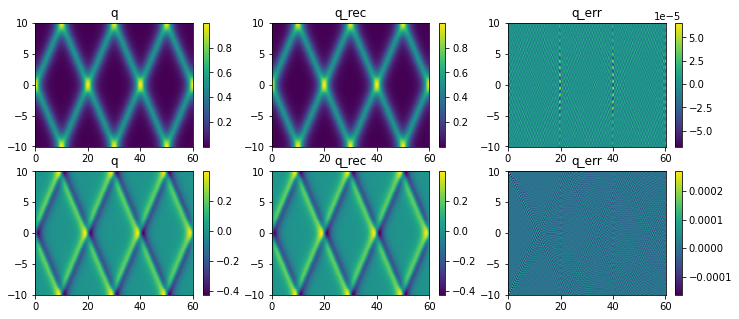

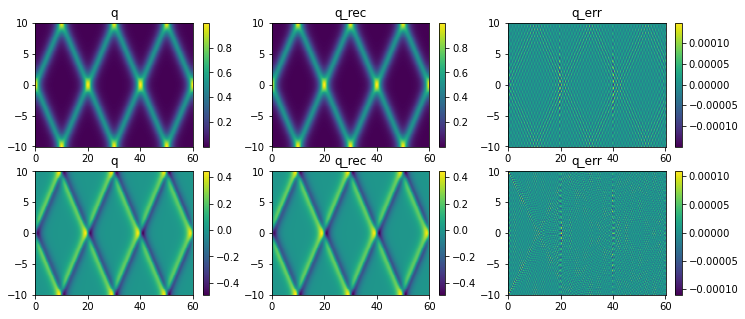

In [32]:
i=0
N = 1201
for i in range(5):
    sol = Xd[:,i*N:(i+1)*N]
    sol_rec = Xd_rec[:,i*N:(i+1)*N]

    fig       = plt.figure(figsize=(12, 5))
    q, p      = sol[:params.N,:], sol[params.N:,:]
    q_rec, p_rec      = sol_rec[:params.N,:], sol_rec[params.N:,:]

    plt.subplot(2,3,1)
    plt.pcolormesh(T,X,q.T)
    plt.colorbar()
    plt.title('q')
    plt.subplot(2,3,2)
    plt.pcolormesh(T,X,q_rec.T)
    plt.colorbar()
    plt.title('q_rec')
    plt.subplot(2,3,3)
    plt.pcolormesh(T,X,q.T-q_rec.T)
    plt.colorbar()
    plt.title('q_err')

    plt.subplot(2,3,4)
    plt.pcolormesh(T,X,p.T)
    plt.colorbar()
    plt.title('q')
    plt.subplot(2,3,5)
    plt.pcolormesh(T,X,p_rec.T)
    plt.colorbar()
    plt.title('q_rec')
    plt.subplot(2,3,6)
    plt.pcolormesh(T,X,p.T-p_rec.T)
    plt.colorbar()
    plt.title('q_err')



# plt.subplot(1,3,2)
# plt.pcolormesh(T,X,p.T)
# plt.colorbar()
# plt.title('p')
# plt.subplot(1,3,3)
# plt.pcolormesh(T,X,abs_phi.T)
# plt.colorbar()
# plt.title('|z|')

In [33]:
sol_train.shape, Xd.shape

((512, 1201), (512, 12010))

In [34]:
# for i in range(len(freqs)):
#     sol = Xd[:,i*N:(i+1)*N]
#     q, p    = sol[:params.N,:], sol[params.N:,:]
#     fig     = plt.figure(figsize=(32, 16))
#     ax      = fig.add_subplot(1, 2, 1, projection='3d')
#     ax.plot_surface(T,X,q.T,cmap='viridis', rasterized=True, rstride=1, cstride=1, alpha=None, antialiased=True)
#     ax      = fig.add_subplot(1, 2, 2, projection='3d')
#     ax.plot_surface(T,X,p.T,cmap='viridis', rasterized=True, rstride=1, cstride=1, alpha=None, antialiased=True)



In [35]:
freqs

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4])